#  Расчет прогнозной модели желтого такси на исторических данных за 2014-2016 год

In [1]:
import pandas as pd
import numpy as np
import pickle
import holidays
from dateutil.rrule import rrule, MONTHLY
from dateutil.relativedelta import relativedelta
from datetime import datetime, date, time, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import clone
import sklearn.preprocessing 
import folium

import statsmodels.api as sm

from itertools import product
import matplotlib.pyplot as plt
import matplotlib
import warnings
%matplotlib inline

In [2]:
data = pd.read_pickle('data_201401-201606.pkl')
data.sample()
data_copy = data.copy()
data_visi = data.copy()

In [3]:
r_ids = np.array([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
       1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
       1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230,
       1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280,
       1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332,
       1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380,
       1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431,
       1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483,
       1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069,
       2118, 2119, 2168])


In [4]:
lon_max, lon_min = -73.70001, -74.25559
lat_max, lat_min = 40.91553, 40.49612

def region_poligon(region):

    lat, lon = (lat_max - lat_min)/50., (lon_max - lon_min)/50.

    a_lat, a_lon = lat_min + (int(region)%50-1)*lat, lon_min + (int(region)/50)*lon
    b_lat, b_lon = lat_min + (int(region)%50)*lat, a_lon
    c_lat, c_lon = b_lat, lon_min + (int(region)/50+1)*lon
    d_lat, d_lon = a_lat, c_lon
        
    return [[[a_lon, a_lat], [b_lon, b_lat], [c_lon, c_lat], [d_lon, d_lat]]]

def prepare_data(start_time,end_time):
    
    geo_data_rezult = []
    cur_time_arr = data_visi[start_time:end_time].index[:-1]
    time_index = [cur_time_arr[0] - relativedelta(days=day_shift, hours=hour_shift) for day_shift in range(0,8) for hour_shift in range(0,24)][1:]

   
    for i in r_ids:
        trip_count = data_visi[i].ix[start_time:end_time].values.sum()
        geo_data_rezult.append({
            "properties": {"name": str(i), "value": trip_count},
            "id": str(i),
            "type": "Feature",
            "geometry": {
                "type": "Polygon",
                "coordinates": region_poligon(i)
            }        
        })

    geo_data = {
        "type": "FeatureCollection",
        "features": geo_data_rezult
    }
    
    return geo_data

In [5]:
# Можно выбрать, на какой временной период на карте будет отображаться спрос на такси
geo_data = prepare_data('2015-01-01 00:00:00','2016-04-30 19:00:00')

In [6]:
# Визуализация спроса на такси

ls_lat,ls_lon = 40.689167, -74.044444

map_ny = folium.Map(location=[(lat_max + lat_min) / 2.0, (lon_max + lon_min) / 2.0], zoom_start=10)
folium.Marker([ls_lat, ls_lon], popup='Liberty Statue').add_to(map_ny)

folium.GeoJson(
    geo_data,
    style_function=lambda feature: {
        'color': '#992800',
        'weight': 0.0,
        'fillOpacity': 0.75 * feature['properties']['value'],
        'dashArray': None
    }).add_to(map_ny)

map_ny

Разметка признаков

In [7]:
r_ids = np.array([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
       1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
       1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230,
       1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280,
       1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332,
       1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380,
       1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431,
       1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483,
       1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069,
       2118, 2119, 2168])


In [8]:
# номируем
max_train_time = '2016-04-30 23:00:00'
data_std = data[:max_train_time].std()
data_mean = data[:max_train_time].mean()

In [9]:
data = (data-data_mean)/data_std

In [10]:
def add_scale_data(region, data):
    return data*data_std[region]+data_mean[region]

In [11]:
#Добавляем признаки
ex_features_data = []
ex_features_data.append(pd.get_dummies(data.index.year, prefix='year'))
ex_features_data.append(pd.get_dummies(data.index.hour, prefix='hour'))
ex_features_data.append(pd.get_dummies(data.index.weekday, prefix='weekday'))
ex_features_data.append(pd.get_dummies(data.index.month, prefix='month'))
ex_features_data.append(pd.get_dummies(data.index.day, prefix='day'))

#begin_ts=datetime(2016,1,1)
#for i in range(1,5):
#    data['cos'+str(i)]=data.apply(lambda x: np.cos((x-begin_ts).total_seconds() // 3600 / 168 + 1))
#    data['sin'+str(i)]=data.apply(lambda x: np.sin((x-begin_ts).total_seconds() // 3600 / 168 + 1))
    
data['num'] = range(1,len(data)+1)
data['const'] = 1.0
ex_features = ['num', 'const']
for i in range(1,5):
    data['cos%i'%i] = np.cos(data['num'] * 2 * np.pi * i / 168.)
    data['sin%i'%i] = np.sin(data['num'] * 2 * np.pi * i / 168.)
    ex_features += ['cos%i'%i, 'sin%i'%i]    

In [12]:
# новые признаки - праздники
holidays_m = []
for date, name in sorted(holidays.US(state='NY', years=[2014,2015,2016]).items()):
    holidays_m.append(date)

In [13]:
data['holiday']=0
for date_m in holidays_m:
    data.ix[(data.index.year==date_m.year) & (data.index.month==date_m.month) & (data.index.day==date_m.day),'holiday'] = 1
ex_features += ['holiday']

In [14]:
# добавим температуру
station = 'KNYNEWYO391' # NY
data_input = pd.read_csv('{}_weather.csv'.format(station))
data_input['DATE'] = pd.to_datetime(data_input['Time'], format='%Y-%m-%d %H')
data_input.set_index('DATE', inplace=True)


In [15]:
data['TemperatureC']=0

for i,inx in enumerate(data_input.index):
    data.ix[data_input.index==inx, 'TemperatureC'] = data_input.iloc[i-1]['TemperatureC']
ex_features += ['TemperatureC']

In [16]:
ex_features_df = pd.concat(ex_features_data, axis=1)
ex_features_df.index = data.index
ex_features_cols = list(ex_features_df.columns)+['holiday','TemperatureC']
data = pd.concat([data, ex_features_df], axis=1)

In [17]:
print ex_features

['num', 'const', 'cos1', 'sin1', 'cos2', 'sin2', 'cos3', 'sin3', 'cos4', 'sin4', 'holiday', 'TemperatureC']


In [18]:
data.sample()

region,1075,1076,1077,1125,1126,1127,1128,1129,1130,1131,...,day_22,day_23,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31
2014-05-12 22:00:00,0.105552,-0.159116,-0.213047,0.352981,0.101142,0.851734,1.513816,0.923099,1.236636,0.34343,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# рассчитаем данные за период
def prepare_data(data, start_time, end_time):
    region1_dict = {region:[] for region in r_ids}
    region2_dict = {region:[] for region in r_ids}
    
    data_cols = ['d%dh%d'%(day_shift, hour_shift) for day_shift in range(0,8) for hour_shift in range(0,24)][1:]+ex_features_cols
    cur_time_arr = data[start_time:end_time].index[:-1]
    time_index = [cur_time_arr[0] - relativedelta(days=day_shift, hours=hour_shift) for day_shift in range(0,8) for hour_shift in range(0,24)][1:]
    answer_time_index = [cur_time_arr[0] + relativedelta(hours=hour_shift) for hour_shift in range(0,6)]
    hour_shift = relativedelta(hours=1)
    for cur_time in cur_time_arr:
        additonal_features = data.ix[cur_time][ex_features_cols].values
        data_features = data[r_ids].ix[time_index].values
        data_answers = data[r_ids].ix[answer_time_index].values
        for i in range(len(r_ids)):
            region1_dict[r_ids[i]].append(np.hstack([data_features[:,i], additonal_features]))
            region2_dict[r_ids[i]].append(data_answers[:,i])
        time_index = [i+hour_shift for i in time_index]
        answer_time_index = [i+hour_shift for i in answer_time_index]
    region1_dict = {k:pd.DataFrame(np.array(v), index=cur_time_arr, columns=data_cols) for k, v in region1_dict.items()}
    region2_dict = {k:pd.DataFrame(np.array(v), index=cur_time_arr) for k, v in region2_dict.items()}
    return region1_dict, region2_dict

In [20]:
%%time
region_before, answers = prepare_data(data, '2015-05-01 00:00:00','2016-04-30 19:00:00')
region_may, tmp = prepare_data(data, '2016-05-01 00:00:00','2016-05-31 19:00:00')
region_june,tmp = prepare_data(data, '2016-06-01 00:00:00','2016-06-30 19:00:00')

Wall time: 4min 4s


In [21]:
region_before[1075].sample()


,d0h1,d0h2,d0h3,d0h4,d0h5,d0h6,d0h7,d0h8,d0h9,d0h10,...,day_24,day_25,day_26,day_27,day_28,day_29,day_30,day_31,holiday,TemperatureC
2015-09-17 23:00:00,1.089006,1.71266,1.520767,0.753193,0.249473,0.70522,-0.134314,0.417379,0.99306,1.13698,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0


In [22]:
def data_to_predicted_dict(region_features, region_answers, region_features_test, est):
    predicted_df_dict = dict()
    for region in r_ids:
        clf_arr = []
        for i in range(6):
            clf = clone(est)
            clf.fit(region_features[region].values, region_answers[region].values[:,i])
            clf_arr.append(clf)

        predicted = np.maximum(0.0, add_scale_data(region, np.array([clf_arr[i].predict(region_features_test[region].values) for i in range(6)]).T).reshape(-1))
        predicted_index = [cur_time+relativedelta(hours=hours_shift) for cur_time in region_features_test[region].index for hours_shift in range(0,6)]
        predicted_df_dict[region] = pd.DataFrame(predicted, index=predicted_index, columns=['pred'])
    return predicted_df_dict

In [23]:
def predicted_dict_to_Q(pred_dict):
    return np.mean([np.mean(np.abs(data_copy[region][pred_dict[region].index].values-pred_dict[region].values.squeeze())) for region in r_ids])

In [24]:
for alpha in [1.0,0.1,0.05]:
    rez_may = data_to_predicted_dict(region_before, answers, region_may, sklearn.linear_model.Lasso(alpha=alpha))
    print("Lasso alpha: %f | MAE за май: %.4f"%(alpha, predicted_dict_to_Q(rez_may)))

Lasso alpha: 1.000000 | MAE за май: 71.3805
Lasso alpha: 0.100000 | MAE за май: 24.8727
Lasso alpha: 0.050000 | MAE за май: 22.5050


In [25]:
for alpha in [1.0,0.1,0.05]:
    rez_may = data_to_predicted_dict(region_before, answers, region_may, sklearn.linear_model.ElasticNet(alpha=alpha))
    print("ElasticNet alpha: %f | MAE за май: %.4f"%(alpha, predicted_dict_to_Q(rez_may)))

ElasticNet alpha: 1.000000 | MAE за май: 56.6370
ElasticNet alpha: 0.100000 | MAE за май: 23.0139
ElasticNet alpha: 0.050000 | MAE за май: 21.5378


Лучшая модель ElasticNet с параметром alpha = 0.05

In [26]:
rez_june = data_to_predicted_dict(region_before, answers, region_june, sklearn.linear_model.ElasticNet(alpha=0.05))

In [27]:
print ("MAE за июнь: %.4f"%predicted_dict_to_Q(rez_june))

MAE за июнь: 19.9276


<function __main__.pltgr>

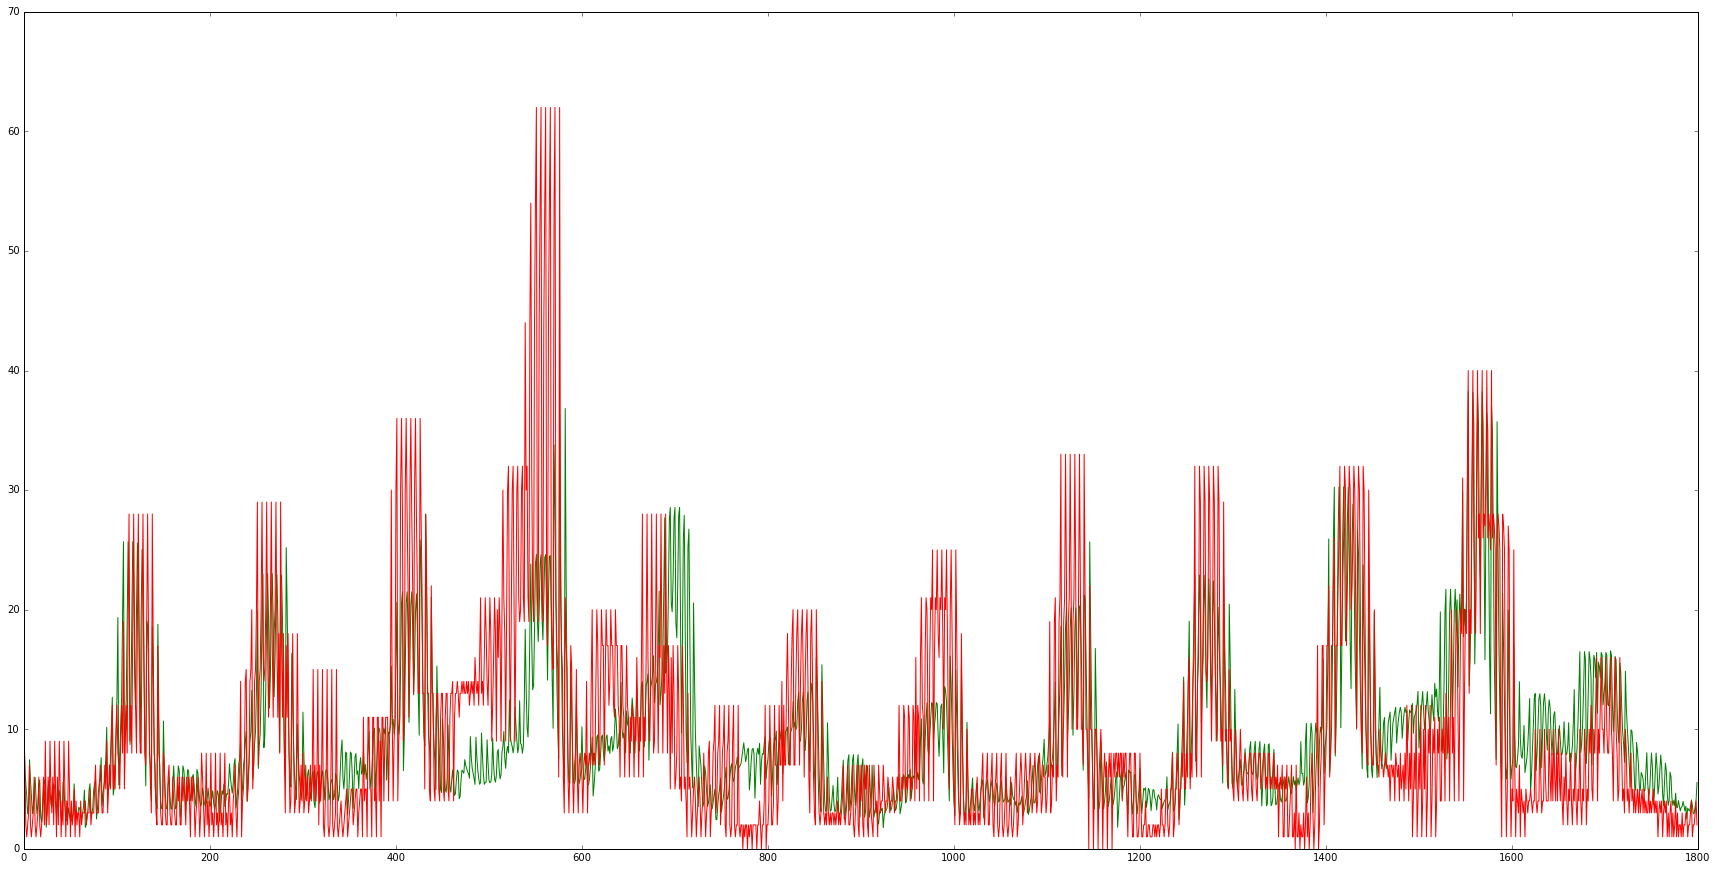

In [28]:
# Визуализацию фактического и прогнозируемого спроса на такси в виде временного ряда в интерактивном варианте

# Можно выбрать, по какому региону будут отображаться временные ряды спроса на такси
region_for_visio   = 1222

#Можно выбрать, на какой временной период на карте будет отображаться спрос на такси  (количество часов)
f_time = 1800

from IPython.html.widgets import *

def pltgr(f):
    plt.figure(figsize=(30, 15))
    plt.plot(rez_june[region_for_visio].values[:f_time], 'g')
    plt.plot(data_copy[region_for_visio][rez_june[region_for_visio].index].values[:f_time], 'r')

interact(pltgr, f=(10,1000,1))